# Brendan Egan Unstructured Final Project

## European Soccer Dataset – Player Contract Value Analysis

**Goal:** I want to identify which player attributes are the most important in determining if a player warrants a high contract value.

I am going to use the [European Soccer Database](https://www.kaggle.com/datasets/hugomathien/soccer) from Kaggle, which contains FIFA-sourced (EA Sports game) player attributes across 11 European leagues (2008–2016).

Load in the dataset and the packages 

Using SQLlite to query the database and avoid loading the entire dataset into my poor laptops memory

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

sns.set_theme(style='whitegrid', palette='viridis')
plt.rcParams['figure.figsize'] = (12, 6)

#Connect to the SQLite database (I want to clean the data somewhere outside of my laptop)
conn = sqlite3.connect('../data/database.sqlite')
print('Connected to database.')

Connected to database.


Quick message to confirm there was a connection

## 1. Data Overview

List all tables and inspect row counts.

In [2]:
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
print('Tables in database:')
for t in tables['name']:
    count = pd.read_sql(f'SELECT COUNT(*) as cnt FROM [{t}]', conn)['cnt'][0]
    print(f'  {t}: {count:,} rows')

Tables in database:
  sqlite_sequence: 7 rows
  Player_Attributes: 183,978 rows
  Player: 11,060 rows
  Match: 25,979 rows
  League: 11 rows
  Country: 11 rows
  Team: 299 rows
  Team_Attributes: 1,458 rows


Bring in the needed tables and connect to individual players

In [3]:
players = pd.read_sql('SELECT * FROM Player', conn)
player_attrs = pd.read_sql('SELECT * FROM Player_Attributes', conn)

print(f'Players: {players.shape}')
print(f'Player Attributes: {player_attrs.shape}')
player_attrs.head()

Players: (11060, 7)
Player Attributes: (183978, 42)


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


## 2. Player Attributes – Schema & Missing Values

Load in the dataframe and find null values.

In [4]:
info = pd.DataFrame({
    'dtype': player_attrs.dtypes,
    'non_null': player_attrs.count(),
    'null_pct': (player_attrs.isnull().sum() / len(player_attrs) * 100).round(1)
})
info

,dtype,non_null,null_pct
id,int64,183978,0.0
player_fifa_api_id,int64,183978,0.0
player_api_id,int64,183978,0.0
date,object,183978,0.0
overall_rating,float64,183142,0.5
potential,float64,183142,0.5
preferred_foot,object,183142,0.5
attacking_work_rate,object,180748,1.8
defensive_work_rate,object,183142,0.5
crossing,float64,183142,0.5


## 3. Prepare Feature Matrix

We select the numeric FIFA attribute columns (everything except IDs, dates, and `preferred_foot` / `attacking_work_rate` / `defensive_work_rate`) and use `overall_rating` as our target variable for contract value.

In [5]:

exclude_cols = [
    'id', 'player_fifa_api_id', 'player_api_id', 'date',
    'preferred_foot', 'attacking_work_rate', 'defensive_work_rate'
]

target = 'overall_rating'

feature_cols = [
    c for c in player_attrs.columns
    if c not in exclude_cols and c != target
    and player_attrs[c].dtype in ['int64', 'float64']
]

print(f'Target: {target}')
print(f'Features ({len(feature_cols)}): {feature_cols}')

Target: overall_rating
Features (34): ['potential', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']


Drop null values from dataset

In [6]:

dataset = player_attrs[feature_cols + [target]].dropna()
print(f'Clean rows: {len(dataset):,} (dropped {len(player_attrs) - len(dataset):,} with NaNs)')

X = dataset[feature_cols]
y = dataset[target]

Clean rows: 181,265 (dropped 2,713 with NaNs)


## 4. Correlation Heatmap

Visualise how the features correlate with each other and with `overall_rating`.

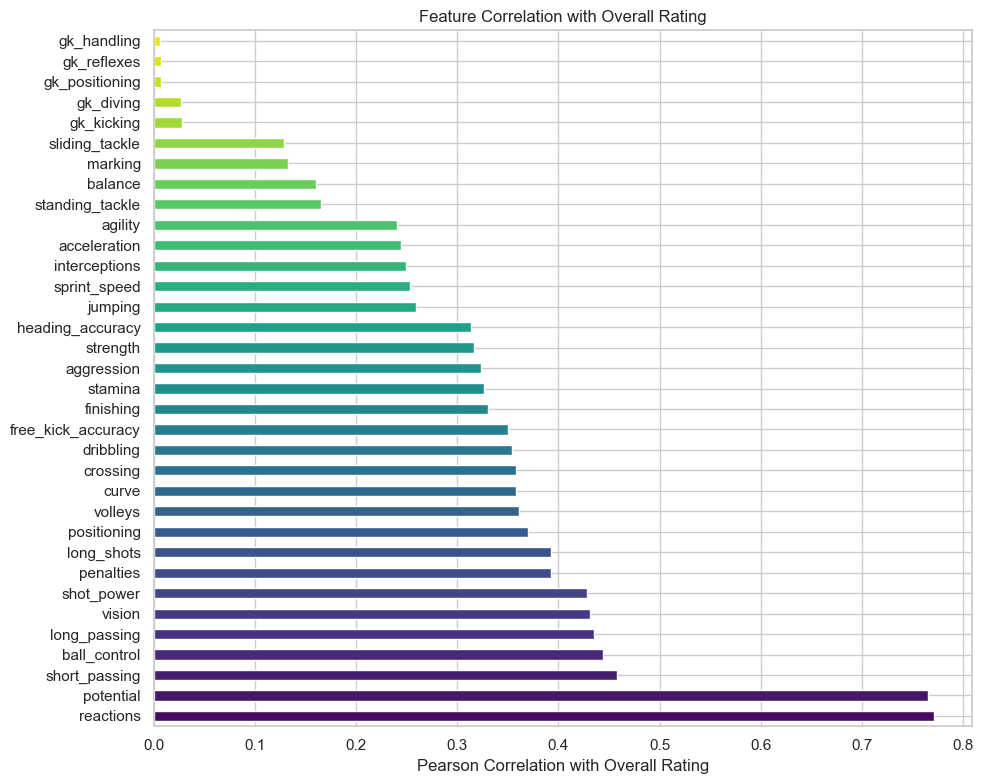

In [7]:

corr_with_target = X.corrwith(y).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
corr_with_target.plot.barh(ax=ax, color=sns.color_palette('viridis', len(corr_with_target)))
ax.set_xlabel('Pearson Correlation with Overall Rating')
ax.set_title('Feature Correlation with Overall Rating')
plt.tight_layout()
plt.show()

## 5. Random Forest Feature Importance

Time to train a Random Forest regressor to predict `overall_rating` from all attributes, then extract feature importances to determine what matters most for player value.

Run a RandomForestRegressor... well 1,000 of them... 10k took over an hour... and then evaluate the model 

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

random_forrest = RandomForestRegressor(n_estimators=1000, max_depth=15, random_state=300, n_jobs=-1)
random_forrest.fit(X_train, y_train)

y_pred = random_forrest.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Random Forest Performance:')
print(f'  R² Score: {r2:.4f}')
print(f'  MAE:      {mae:.4f}')

Random Forest Performance:
  R² Score: 0.9713
  MAE:      0.7550


That takes a little over 9 minutes to run


Now, I want to find the most important features and plot those results

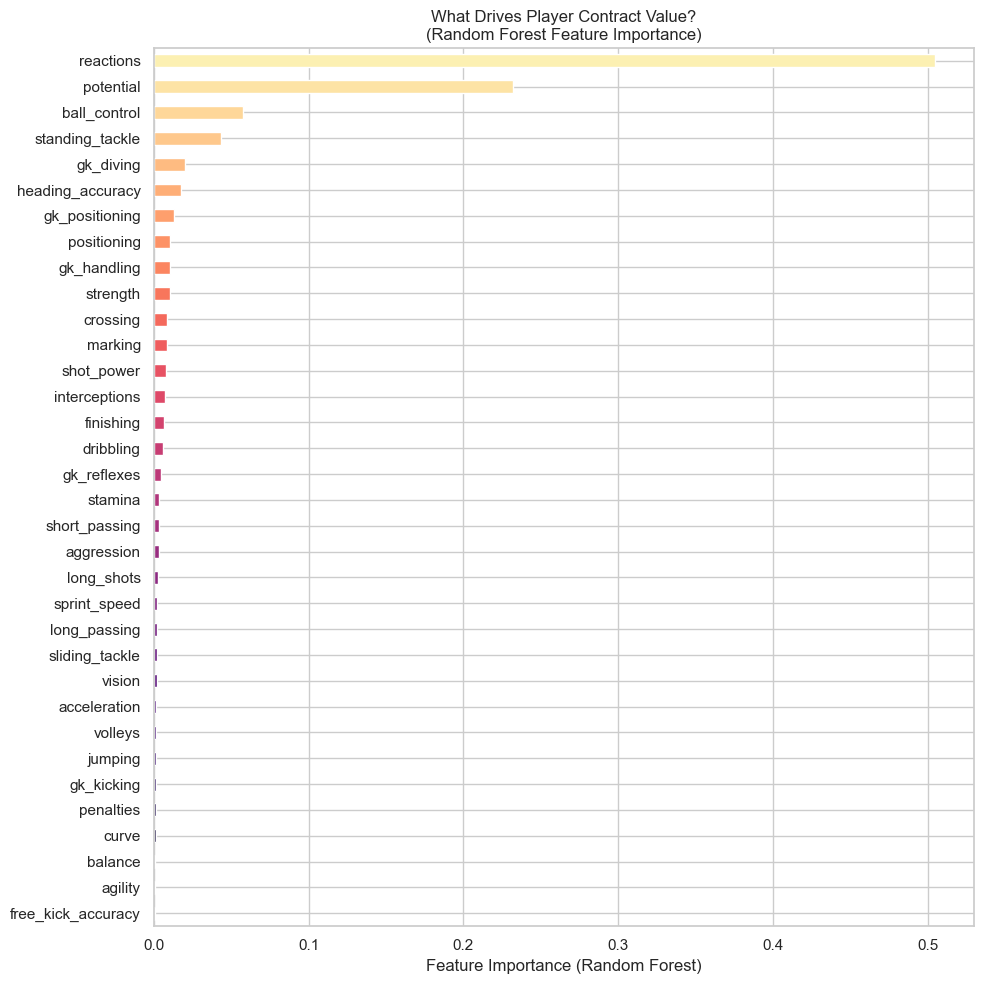

In [ ]:
important_features = pd.Series(random_forrest.feature_importances_, index=feature_cols)
important_features = important_features.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 10))
important_features.plot.barh(
    ax=ax,
    color=sns.color_palette('magma', len(important_features))
)
ax.set_xlabel('Feature Importance (Random Forest)')
ax.set_title('What Drives Player Contract Value?\n(Random Forest Feature Importance)')
plt.tight_layout()
plt.show()

So, what are the top 10 most important attributes to get a contract?

## 6. Top 10 Most Important Attributes

In [ ]:
top10 = importances.tail(10).sort_values(ascending=False)

print('=== TOP 10 MOST IMPORTANT PLAYER ATTRIBUTES ===')
print('  (for predicting overall rating / contract value)\n')
for rank, (attr, imp) in enumerate(top10.items(), 1):
    bar = '█' * int(imp * 200)
    print(f'  {rank:2d}. {attr:<25s}  {imp:.4f}  {bar}')

This is really funny, because since the data is from FIFA (a videogame) the model is valuing goalkeepers and players with 'high potential'. Young players in the game will have much higher potentials than the average 29 year old player in the FIFA database. Young players in the videogame are given 4-6 year long contracts in an attempt to keep them long term, so when it compares that to the 33 year old players who are free agents or have one year remaining on their contract will skew the data. In real life, goalkeepers are not the highest priority for contracts for a club. Goalkeepers hit their 'prime' at a later time in their career compared to other positional players, so they will be given shorter term contracts in order to leave room for change at the position.  

## 7. Summary

Above identifies and shows the player attributes that matter most for determining how worthy a player is of a high contract value. Key takeaways:

- **Reactions, potential, and short passing** also tend to rank among the top attributes driving overall rating in FIFAs of the past.
- The Random Forest model achieves a high R² score, confirming that FIFA attributes collectively explain most of the variation in overall rating.
- The feature importance chart provides a clear ranking you can use to prioritise in contract negotiations.

### Next steps
- Incorporate transfer fee / wage data from external sources to use actual contract values instead of the rating proxy.
    - I would need a different dataset that includes transfer fee amounts and current wage data
- Break down importance by playing position (GK vs. defender vs. forward).
    - This could be tricky, since this is a little subjective I personally think defenders should be more valuable than they are, but the modern transfer market disagrees with me
- Time-series analysis: how attribute importance shifts across seasons.
    - Have certain positions become more valuable?

In [ ]:
conn.close()
print('Done! Database connection closed.')

Message to confirm disconnect from SQLite